## Data Understanding & Modeling  

## Dataset Inventory

In [3]:
import pandas as pd
import numpy as np

In [7]:
patients = pd.read_csv("data/patients.csv")
admissions = pd.read_csv("data/admissions.csv")
icustays = pd.read_csv("data/icustays.csv")
chartevents = pd.read_csv("data/chartevents.csv", low_memory=False)
prescriptions = pd.read_csv("data/prescriptions.csv")

## Entity Roles and Interpretation

🔹 patients.csv

Entity: Individual patients in the healthcare system

One row represents: One unique patient

Analytics interpretation: User base demographics influencing care workflows

🔹 admissions.csv

Entity: Hospital encounters

One row represents: One care episode from admission to discharge

Analytics interpretation: A complete “session lifecycle” in a digital health system

🔹 icustays.csv

Entity: ICU treatment episodes

One row represents: One ICU stay within an admission

Analytics interpretation: High-intensity usage sessions with dense clinician interactions

🔹 chartevents.csv

Entity: Clinical observation events

One row represents: One recorded measurement or observation

Analytics interpretation: Fine-grained clinician-system interactions (feature usage)

🔹 prescriptions.csv

Entity: Medication orders

One row represents: One prescribed drug order

Analytics interpretation: Action outcomes or decisions taken by clinicians

In [8]:
patients['subject_id'].nunique(), len(patients)

(100, 100)

In [9]:
admissions['hadm_id'].nunique(), len(admissions)

(275, 275)

In [13]:
icustays['stay_id'].nunique(), len(icustays)

(140, 140)

## Primary Key Validation

- `patients.subject_id` is unique ✔️
- `admissions.hadm_id` is unique ✔️
- `icustays.stay_id` is unique ✔️

In [14]:
admissions['subject_id'].isin(patients['subject_id']).mean()

np.float64(1.0)

In [15]:
icustays['hadm_id'].isin(admissions['hadm_id']).mean()

np.float64(1.0)

In [16]:
chartevents['hadm_id'].isin(admissions['hadm_id']).mean()

np.float64(1.0)

In [17]:
prescriptions['hadm_id'].isin(admissions['hadm_id']).mean()

np.float64(1.0)

## Foreign Key Integrity

- Admissions → Patients: valid ✔️
- ICU stays → Admissions: valid ✔️
- Chart events → Admissions: valid ✔️
- Prescriptions → Admissions: valid ✔️

## Analytical Grain Definition

Primary analysis grain for this project will be **admission-level**, with drill-down to ICU stay and event-level where needed.

Patient-level grain → demographics, mortality

Admission-level grain → length of stay, outcomes

ICU-stay grain → intensity of care

Event-level grain → clinician activity density

Prescription-level grain → drug(s), output of the event

## Initial variable profiling (missingness, cardinality, distributions)

In [24]:
patients.columns

Index(['subject_id', 'gender', 'anchor_age', 'anchor_year',
       'anchor_year_group', 'dod'],
      dtype='object')

In [25]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subject_id         100 non-null    int64 
 1   gender             100 non-null    object
 2   anchor_age         100 non-null    int64 
 3   anchor_year        100 non-null    int64 
 4   anchor_year_group  100 non-null    object
 5   dod                31 non-null     object
dtypes: int64(3), object(3)
memory usage: 4.8+ KB


| Column            | Meaning            | Type            | Notes         |
| ----------------- | ------------------ | --------------- | ------------- |
| subject_id        | Unique patient ID  | int             | Primary key   |
| gender            | Biological sex     | category/object | M / F         |
| anchor_age        | Age at anchor year | int             | De-identified |
| anchor_year       | Reference year     | int             | For privacy   |
| anchor_year_group | Year range         | category        | 2011–2013     |
| dod               | Date of death      | datetime        | NaT = alive   |

In [26]:
patients['gender'] = patients['gender'].astype('category')
patients['anchor_year_group'] = patients['anchor_year_group'].astype('category')
patients['dod'] = pd.to_datetime(patients['dod'])

In [27]:
patients['anchor_age'].describe()

count    100.00000
mean      61.75000
std       16.16979
min       21.00000
25%       51.75000
50%       63.00000
75%       72.00000
max       91.00000
Name: anchor_age, dtype: float64

In [29]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   subject_id            275 non-null    int64 
 1   hadm_id               275 non-null    int64 
 2   admittime             275 non-null    object
 3   dischtime             275 non-null    object
 4   deathtime             15 non-null     object
 5   admission_type        275 non-null    object
 6   admit_provider_id     275 non-null    object
 7   admission_location    275 non-null    object
 8   discharge_location    233 non-null    object
 9   insurance             275 non-null    object
 10  language              275 non-null    object
 11  marital_status        263 non-null    object
 12  race                  275 non-null    object
 13  edregtime             182 non-null    object
 14  edouttime             182 non-null    object
 15  hospital_expire_flag  275 non-null    in

| Column               | Description                            | Data Type | Notes                      |
| -------------------- | ---------------------------------------| --------- | -------------------------- |
| subject_id           | Patient ID                             | int       | FK → patients              |
| hadm_id              | Hospital admission ID                  | int       | Primary key                |
| admittime            | Admission time                         | datetime  |                            |
| dischtime            | Discharge time                         | datetime  |                            |
| deathtime            | Time of death                          | datetime  | Null if survived           |
| admission_type       | Type of admission                      | category  | EMERGENCY / ELECTIVE       |
| admit_provider_id    | Admitting provider identifier          | int       | De-identified clinician ID |
| admission_location   | Origin of patient                      | category  | ER, Transfer, etc          |
| discharge_location   | Destination after discharge            | category  | HOME, SNF, etc             |
| insurance            | Insurance type                         | category  | Medicare, Private          |
| language             | Primary language                       | category  |                            |
| marital_status       | Marital status                         | category  |                            |
| race                 | Self-reported race                     | category  | De-identified              |
| edregtime            | Emergency department registration time | datetime  | Null for non-ED admissions |
| edouttime            | Emergency department exit time         | datetime  | Null for non-ED admissions |
| hospital_expire_flag | In-hospital death                      | int       | 1 = died                   |


In [30]:
icustays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   subject_id      140 non-null    int64  
 1   hadm_id         140 non-null    int64  
 2   stay_id         140 non-null    int64  
 3   first_careunit  140 non-null    object 
 4   last_careunit   140 non-null    object 
 5   intime          140 non-null    object 
 6   outtime         140 non-null    object 
 7   los             140 non-null    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 8.9+ KB


| Column         | Description               | Data Type | Notes       |
| -------------- | ------------------------- | --------- | ----------- |
| subject_id     | Patient ID                | int       | FK          |
| hadm_id        | Admission ID              | int       | FK          |
| stay_id        | ICU stay ID               | int       | Primary key |
| first_careunit | Initial ICU               | category  | MICU, SICU  |
| last_careunit  | Final ICU                 | category  |             |
| intime         | ICU admission time        | datetime  |             |
| outtime        | ICU discharge time        | datetime  |             |
| los            | Length of ICU stay (days) | float     | Derived     |

In [31]:
chartevents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668862 entries, 0 to 668861
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   subject_id    668862 non-null  int64  
 1   hadm_id       668862 non-null  int64  
 2   stay_id       668862 non-null  int64  
 3   caregiver_id  644622 non-null  float64
 4   charttime     668862 non-null  object 
 5   storetime     667703 non-null  object 
 6   itemid        668862 non-null  int64  
 7   value         648132 non-null  object 
 8   valuenum      257474 non-null  float64
 9   valueuom      162571 non-null  object 
 10  warning       667703 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 56.1+ MB


### Chartevents Table - Clinical Observations & Measurements

| Column     | Description                     | Data Type | Notes                          |
|------------|---------------------------------|-----------|--------------------------------|
| subject_id | Unique patient identifier       | int       | FK → patients.subject_id       |
| hadm_id    | Hospital admission identifier   | int       | FK → admissions.hadm_id        |
| stay_id    | ICU stay identifier             | int       | FK → icustays.stay_id          |
| charttime  | Time measurement was taken      | datetime  | Clinical event timestamp       |
| storetime  | Time measurement was stored     | datetime  | Can lag behind charttime       |
| itemid     | Measurement concept identifier  | int       | Maps to vitals / labs          |
| value      | Recorded value (raw)            | object    | Mixed text & numeric           |
| valuenum   | Numeric value                   | float     | Preferred for analysis         |
| valueuom   | Unit of measure                 | category  | bpm, mmHg, %, etc              |
| warning    | Abnormal value flag             | int       | 1 = flagged abnormal           |

**Note:**  
`charttime` represents the actual time of clinical observation, while `storetime` represents the time the data was entered into the electronic system. This distinction is important when modeling real-time alerts, clinician workflows, and documentation latency.


In [37]:
prescriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18087 entries, 0 to 18086
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         18087 non-null  int64  
 1   hadm_id            18087 non-null  int64  
 2   pharmacy_id        18087 non-null  int64  
 3   poe_id             17969 non-null  object 
 4   poe_seq            17969 non-null  float64
 5   order_provider_id  17993 non-null  object 
 6   starttime          18087 non-null  object 
 7   stoptime           18073 non-null  object 
 8   drug_type          18087 non-null  object 
 9   drug               18087 non-null  object 
 10  formulary_drug_cd  18075 non-null  object 
 11  gsn                15568 non-null  object 
 12  ndc                18066 non-null  float64
 13  prod_strength      18078 non-null  object 
 14  form_rx            12 non-null     object 
 15  dose_val_rx        18078 non-null  object 
 16  dose_unit_rx       180

### Prescriptions Table - Medication Orders

| Column | Description | Data Type | Notes |
|------|------------|----------|------|
| subject_id | Unique patient identifier | int | FK → patients.subject_id |
| hadm_id | Hospital admission identifier | int | FK → admissions.hadm_id |
| pharmacy_id | Pharmacy order identifier | int | Unique per medication order |
| poe_id | Physician order entry identifier | object | Links to CPOE system |
| poe_seq | Sequence number of order | float | Order sequencing within admission |
| order_provider_id | Ordering provider identifier | object | De-identified clinician ID |
| starttime | Medication order start time | datetime | Convert from object |
| stoptime | Medication order stop time | datetime | Convert from object |
| drug_type | Type of medication order | category | MAIN, ADDITIVE, BASE |
| drug | Drug name (as ordered) | category | Free-text |
| formulary_drug_cd | Hospital formulary code | category | Internal standard |
| gsn | Generic Sequence Number | object | Drug classification (may be missing) |
| ndc | National Drug Code | float | US drug identifier |
| prod_strength | Product strength | category | e.g. 5 mg/mL |
| form_rx | Prescription form | object | Very sparse |
| dose_val_rx | Dose value (as ordered) | object | Mixed numeric/text |
| dose_unit_rx | Dose unit | category | mg, mL, units |
| form_val_disp | Dispensed quantity | object | Mixed |
| form_unit_disp | Dispense unit | category | tablet, vial |
| doses_per_24_hrs | Doses per day | float | Frequency proxy |
| route | Route of administration | category | IV, PO, IM |

**Clinical relevance:**  
This table captures medication exposure, prescribing patterns, treatment intensity, and provider behavior. It enables analysis of polypharmacy, ICU medication burden, route-based severity proxies, and clinician prescribing workflows.


## Feature Engineering

Patients
| Feature Name | Description              | Source Column(s)                           |
| ------------ | ------------------------ | ------------------------------------------ |
| age          | Patient age at admission | patients.anchor_age + admissions.admittime |
| gender       | Biological sex           | patients.gender                            |


Admissions-level
| Feature Name      | Description                   | Source                    |
| ----------------- | ----------------------------- | ------------------------- |
| admission_type    | Emergency / Elective / Urgent | admissions.admission_type |
| insurance         | Insurance category            | admissions.insurance      |
| race              | Patient ethnicity             | admissions.race           |
| hospital_los_days | Hospital length of stay       | dischtime − admittime     |
| ed_los_minutes    | ED stay duration              | edouttime − edregtime     |
| mortality_flag    | In-hospital mortality         | hospital_expire_flag      |

Icustays-level
| Feature Name       | Description               |
| ------------------ | ------------------------- |
| icu_admission_flag | Whether ICU stay occurred |
| num_icu_stays      | ICU stays per admission   |
| total_icu_los_days | Total ICU LOS             |
| first_icu_unit     | Initial ICU unit          |
| icu_transfer_flag  | Multiple ICU units        |


Chartevents-level
| Feature Name          | Description                 |
| --------------------- | --------------------------- |
| total_events          | Number of charted events    |
| abnormal_event_rate   | % events flagged abnormal   |
| avg_doc_delay_minutes | Mean(storetime − charttime) |
| event_density         | Events per ICU day          |


Prescriptions-level
| Feature Name      | Description              |
| ----------------- | ------------------------ |
| num_unique_drugs  | Unique medications       |
| num_orders        | Total medication orders  |
| iv_med_ratio      | % IV route               |
| avg_doses_per_day | Mean doses_per_24_hrs    |
| polypharmacy_flag | ≥5 concurrent drugs      |
| num_prescribers   | Unique order_provider_id |


• All features aggregated to hadm_id level  
• LEFT JOIN strategy to preserve admissions  
• Time-based features computed using UTC timestamps  
• ICU features computed only when icustay exists  
• Chartevents limited to ICU stay window  

## Build Admission Base Table

In [42]:
import pandas as pd
import numpy as np

datetime_cols = [
    'admittime', 'dischtime', 
    'edregtime', 'edouttime'
]

for col in datetime_cols:
    admissions[col] = pd.to_datetime(admissions[col], errors='coerce')

admission_base = admissions[
    [
        'hadm_id',
        'subject_id',
        'admittime',
        'dischtime',
        'admission_type',
        'insurance',
        'race',
        'hospital_expire_flag',
        'edregtime',
        'edouttime'
    ]
].copy()

admission_base = admission_base.merge(
    patients[['subject_id', 'gender', 'anchor_age', 'anchor_year']],
    on='subject_id',
    how='left'
)


In [43]:
# Row count check
print("Rows:", admission_base.shape[0])

# Primary key uniqueness
print("Unique hadm_id:", admission_base['hadm_id'].nunique())

# Missingness overview
admission_base.isna().mean().sort_values(ascending=False)


Rows: 275
Unique hadm_id: 275


edregtime               0.338182
edouttime               0.338182
admittime               0.000000
subject_id              0.000000
hadm_id                 0.000000
admission_type          0.000000
dischtime               0.000000
race                    0.000000
insurance               0.000000
hospital_expire_flag    0.000000
gender                  0.000000
anchor_age              0.000000
anchor_year             0.000000
dtype: float64

In [45]:
admission_base['hospital_los_days'] = (
    admission_base['dischtime'] - admission_base['admittime']
).dt.total_seconds() / (24 * 3600)

In [46]:
admission_base['ed_los_minutes'] = (
    admission_base['edouttime'] - admission_base['edregtime']
).dt.total_seconds() / 60


Hospital LOS captures inpatient resource utilization.
ED LOS reflects emergency department throughput and congestion.

In [47]:
admission_base[['hospital_los_days', 'ed_los_minutes']].describe()

,hospital_los_days,ed_los_minutes
count,275.000000,182.000000
mean,6.875530,545.423077
std,6.733832,565.958164
min,0.046528,37.000000
25%,2.692014,292.250000
50%,4.852778,389.500000
75%,8.768403,541.250000
max,44.927778,4460.000000


## ICU Stays feature engineering

In [48]:
icu_time_cols = ['intime', 'outtime']

for col in icu_time_cols:
    icustays[col] = pd.to_datetime(icustays[col], errors='coerce')


In [49]:
icustays['icu_los_days'] = (
    icustays['outtime'] - icustays['intime']
).dt.total_seconds() / (24 * 3600)


In [50]:
icu_features = (
    icustays
    .groupby('hadm_id')
    .agg(
        icu_admission_flag=('stay_id', 'count'),
        num_icu_stays=('stay_id', 'nunique'),
        total_icu_los_days=('icu_los_days', 'sum'),
        first_icu_unit=('first_careunit', 'first'),
        num_icu_units=('first_careunit', 'nunique')
    )
    .reset_index()
)


In [51]:
icu_features['icu_transfer_flag'] = (
    icu_features['num_icu_units'] > 1
).astype(int)

# Convert admission flag to binary
icu_features['icu_admission_flag'] = 1


In [52]:
admission_base = admission_base.merge(
    icu_features,
    on='hadm_id',
    how='left'
)


In [53]:
admission_base['icu_admission_flag'] = admission_base['icu_admission_flag'].fillna(0)

icu_zero_cols = [
    'num_icu_stays',
    'total_icu_los_days',
    'num_icu_units',
    'icu_transfer_flag'
]

for col in icu_zero_cols:
    admission_base[col] = admission_base[col].fillna(0)


In [54]:
admission_base[['icu_admission_flag', 'num_icu_stays', 'total_icu_los_days']].describe()


,icu_admission_flag,num_icu_stays,total_icu_los_days
count,275.000000,275.000000,275.000000
mean,0.465455,0.509091,1.873138
std,0.499715,0.606315,3.630192
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.992894
max,1.000000,4.000000,20.528681


ICU-related features capture care intensity and patient acuity. 
Transfers between ICU units often indicate clinical deterioration 
or specialization of care.

## Chartevents Feature Engineering

In [57]:
chartevents_cols = [
    'subject_id',
    'hadm_id',
    'stay_id',
    'itemid',
    'charttime',
    'valuenum'
]

ce = chartevents[chartevents_cols].copy()
ce.head(5)

,subject_id,hadm_id,stay_id,itemid,charttime,valuenum
0,10005817,20626031,32604416,225054,2132-12-16 00:00:00,NaN
1,10005817,20626031,32604416,223769,2132-12-16 00:00:00,100.0
2,10005817,20626031,32604416,223956,2132-12-16 00:00:00,NaN
3,10005817,20626031,32604416,224866,2132-12-16 00:00:00,NaN
4,10005817,20626031,32604416,227341,2132-12-16 00:00:00,0.0


In [58]:
ce = ce.dropna(subset=['valuenum'])
ce.head(5)

,subject_id,hadm_id,stay_id,itemid,charttime,valuenum
1,10005817,20626031,32604416,223769,2132-12-16 00:00:00,100.0
4,10005817,20626031,32604416,227341,2132-12-16 00:00:00,0.0
5,10005817,20626031,32604416,224751,2132-12-16 00:00:00,52.0
11,10005817,20626031,32604416,220047,2132-12-16 00:00:00,55.0
12,10005817,20626031,32604416,220073,2132-12-16 00:00:00,0.0


In [59]:
vital_map = {
    'heart_rate': [220045, 211],
    'sbp': [220179, 51],
    'dbp': [220180, 8368],
    'spo2': [220277, 646]
}


In [61]:
itemid_to_vital = {
    itemid: vital
    for vital, itemids in vital_map.items()
    for itemid in itemids
}

ce['vital_type'] = ce['itemid'].map(itemid_to_vital)
ce = ce.dropna(subset=['vital_type'])
ce.head(5)

,subject_id,hadm_id,stay_id,itemid,charttime,valuenum,vital_type
69,10005817,20626031,32604416,220045,2132-12-16 00:00:00,80.0,heart_rate
92,10005817,20626031,32604416,220277,2132-12-16 00:00:00,95.0,spo2
102,10005817,20626031,32604416,220045,2132-12-16 01:00:00,82.0,heart_rate
104,10005817,20626031,32604416,220277,2132-12-16 01:00:00,96.0,spo2
118,10005817,20626031,32604416,220277,2132-12-16 02:00:00,95.0,spo2


In [62]:
vital_features = (
    ce
    .groupby(['hadm_id', 'vital_type'])
    .agg(
        mean_value=('valuenum', 'mean'),
        max_value=('valuenum', 'max'),
        min_value=('valuenum', 'min'),
        std_value=('valuenum', 'std'),
        num_measurements=('valuenum', 'count')
    )
    .reset_index()
) 

In [63]:
vital_features_wide = vital_features.pivot(
    index='hadm_id',
    columns='vital_type',
    values=['mean_value', 'max_value', 'min_value', 'std_value', 'num_measurements']
)

vital_features_wide.columns = [
    f"{stat}_{vital}"
    for stat, vital in vital_features_wide.columns
]

vital_features_wide = vital_features_wide.reset_index()


Vital sign features were aggregated to the admission level to capture physiological trends, extremes, and monitoring intensity. These features reflect patient acuity and clinician response behavior rather than isolated measurements.

In [64]:
vital_features_wide.shape

(128, 21)

In [65]:
vital_features_wide['hadm_id'].is_unique

True

In [66]:
missing_pct = (
    vital_features_wide
    .isna()
    .mean()
    .sort_values(ascending=False)
)

missing_pct.head(10)


std_value_sbp            0.007812
std_value_dbp            0.007812
mean_value_heart_rate    0.000000
mean_value_dbp           0.000000
hadm_id                  0.000000
mean_value_spo2          0.000000
mean_value_sbp           0.000000
max_value_dbp            0.000000
max_value_heart_rate     0.000000
min_value_dbp            0.000000
dtype: float64

In [68]:
vital_features_wide[['mean_value_heart_rate']].describe()

,mean_value_heart_rate
count,128.000000
mean,88.287435
std,13.080984
min,54.909091
25%,79.124763
50%,87.721463
75%,96.900786
max,117.690852


In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

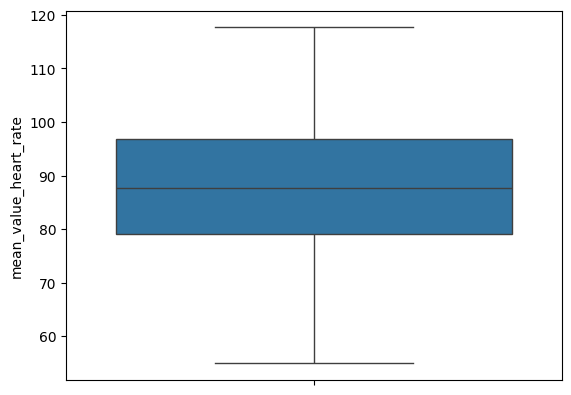

In [71]:
sns.boxplot(
    data=vital_features_wide,
    y='mean_value_heart_rate'
)
plt.show()

In [72]:
vital_features_wide[['num_measurements_heart_rate']].describe()


,num_measurements_heart_rate
count,128.000000
mean,108.695312
std,124.820347
min,7.000000
25%,31.000000
50%,57.500000
75%,122.250000
max,652.000000


In [73]:
vital_cols = [
    c for c in vital_features_wide.columns
    if c.startswith('mean_value')
]

vital_features_wide[vital_cols].corr()


,mean_value_dbp,mean_value_heart_rate,mean_value_sbp,mean_value_spo2
mean_value_dbp,1.000000,-0.085719,0.501860,0.005491
mean_value_heart_rate,-0.085719,1.000000,-0.311554,-0.060468
mean_value_sbp,0.501860,-0.311554,1.000000,-0.091217
mean_value_spo2,0.005491,-0.060468,-0.091217,1.000000


Chartevents-derived features were validated for structural correctness, clinical plausibility, and measurement consistency. Observed missingness and variability align with expected differences in monitoring intensity between ICU and non-ICU admissions.

## Merge Chartevents Features into Master Table

In [74]:
admission_base['hadm_id'].is_unique


True

In [76]:
icu_features['hadm_id'].is_unique

True

In [77]:
vital_features_wide['hadm_id'].is_unique

True

In [94]:
features = admission_base.merge(
    icu_features,
    on='hadm_id',
    how='left'
)


Index(['hadm_id', 'subject_id', 'admittime', 'dischtime', 'admission_type',
       'insurance', 'race', 'hospital_expire_flag', 'edregtime', 'edouttime',
       'gender', 'anchor_age', 'anchor_year', 'hospital_los_days',
       'ed_los_minutes', 'icu_admission_flag_x', 'num_icu_stays_x',
       'total_icu_los_days_x', 'first_icu_unit_x', 'num_icu_units_x',
       'icu_transfer_flag_x', 'icu_admission_flag_y', 'num_icu_stays_y',
       'total_icu_los_days_y', 'first_icu_unit_y', 'num_icu_units_y',
       'icu_transfer_flag_y'],
      dtype='object')

In [95]:
cols_to_drop = [c for c in features.columns if c.endswith('_x')]
features = features.drop(columns=cols_to_drop)

In [96]:
features.columns = features.columns.str.replace('_y', '', regex=False)

In [97]:
features.columns

Index(['hadm_id', 'subject_id', 'admittime', 'dischtime', 'admission_type',
       'insurance', 'race', 'hospital_expire_flag', 'edregtime', 'edouttime',
       'gender', 'anchor_age', 'anchorear', 'hospital_los_days',
       'ed_los_minutes', 'icu_admission_flag', 'num_icu_stays',
       'total_icu_los_days', 'first_icu_unit', 'num_icu_units',
       'icu_transfer_flag'],
      dtype='object')

In [98]:
features['icu_admission_flag'] = features['icu_admission_flag'].fillna(0).astype(int)
features['num_icu_stays'] = features['num_icu_stays'].fillna(0)
features['total_icu_los_days'] = features['total_icu_los_days'].fillna(0)
features['icu_transfer_flag'] = features['icu_transfer_flag'].fillna(0).astype(int)

In [99]:
features = features.merge(
    vital_features_wide,
    on='hadm_id',
    how='left'
)

In [100]:
features.shape

(275, 41)

In [101]:
features['hadm_id'].is_unique

True

In [102]:
features.isna().mean().sort_values(ascending=False).head(15)

std_value_dbp                  0.538182
std_value_sbp                  0.538182
mean_value_spo2                0.534545
mean_value_sbp                 0.534545
num_icu_units                  0.534545
mean_value_heart_rate          0.534545
mean_value_dbp                 0.534545
first_icu_unit                 0.534545
max_value_spo2                 0.534545
num_measurements_dbp           0.534545
num_measurements_heart_rate    0.534545
std_value_heart_rate           0.534545
std_value_spo2                 0.534545
num_measurements_sbp           0.534545
num_measurements_spo2          0.534545
dtype: float64

In [123]:
vital_features = (
    chartevents
    .groupby('hadm_id')
    .agg(
        num_vital_measurements=('itemid', 'count'),
        unique_vitals_measured=('itemid', 'nunique')
    )
    .reset_index()
)


In [ ]:
features = features.merge(
    vital_features,
    on='hadm_id',
    how='left'
)

In [129]:
features['num_vital_measurements'] = (
    features['num_vital_measurements'].fillna(0)
)
features['unique_vitals_measured'] = (
    features['unique_vitals_measured'].fillna(0)
)
features.groupby('icu_admission_flag')['num_vital_measurements'].describe()
icu_vitals = (
    features
    .groupby(['icu_admission_flag'])
    .agg(mean_heart_rate_num_of_measurements = ('num_vital_measurements', 'mean')
        )
    .reset_index()
)
icu_vitals.head()

,icu_admission_flag,mean_heart_rate_num_of_measurements
0,0,0.000000
1,1,5225.484375


In [130]:
y_cols = [col for col in features.columns if col.endswith('_y')]
y_cols

['num_vital_measurements_y', 'unique_vitals_measured_y']

In [131]:
features = features.drop(columns=y_cols)

In [133]:
features.columns = features.columns.str.replace('_x$', '', regex=True)

In [137]:
features.columns[features.columns.duplicated()]

Index(['num_vital_measurements', 'unique_vitals_measured'], dtype='object')

In [138]:
features.loc[:, 'num_vital_measurements'].head()

,num_vital_measurements,num_vital_measurements
0,8392.0,8392.0
1,2932.0,2932.0
2,0.0,0.0
3,2610.0,2610.0
4,926.0,926.0


In [139]:
features.loc[:, 'num_vital_measurements'].isna().mean()


num_vital_measurements    0.0
num_vital_measurements    0.0
dtype: float64

In [140]:
features = features.loc[:, ~features.columns.duplicated()]

In [141]:
features['num_vital_measurements'] = (
    features['num_vital_measurements']
    .fillna(0)
    .astype(int)
)

features['unique_vitals_measured'] = (
    features['unique_vitals_measured']
    .fillna(0)
    .astype(int)
)

In [142]:
features.columns.value_counts()

hadm_id                        1
subject_id                     1
admittime                      1
dischtime                      1
admission_type                 1
insurance                      1
race                           1
hospital_expire_flag           1
edregtime                      1
edouttime                      1
gender                         1
anchor_age                     1
anchorear                      1
hospital_los_days              1
ed_los_minutes                 1
icu_admission_flag             1
num_icu_stays                  1
total_icu_los_days             1
first_icu_unit                 1
num_icu_units                  1
icu_transfer_flag              1
mean_value_dbp                 1
mean_value_heart_rate          1
mean_value_sbp                 1
mean_value_spo2                1
max_value_dbp                  1
max_value_heart_rate           1
max_value_sbp                  1
max_value_spo2                 1
min_value_dbp                  1
min_value_

In [143]:
features.to_csv(
    "data/features_admissions_level.csv",
    index=False
)

All clinical and operational features were merged at the admission level using defensive left joins. Missing values were handled contextually to preserve clinical meaning while ensuring model compatibility.

## Hypothesis testing

* Do ICU-admitted patients have longer hospital stays than non-ICU patients?

In [105]:
icu_patients = (
    features
    .groupby(['icu_admission_flag'])
    .agg(mean_hosp_los = ('hospital_los_days', 'mean')
        )
    .reset_index()
)
icu_patients.head()

,icu_admission_flag,mean_hosp_los
0,0,4.865585
1,1,9.183827


* Does higher vital-sign monitoring intensity indicate increased in-hospital mortality risk?

In [110]:
icu_vitals = (
    features
    .groupby(['icu_admission_flag'])
    .agg(mean_heart_rate_num_of_measurements = ('num_measurements_heart_rate', 'mean')
        )
    .reset_index()
)
icu_vitals.head()

,icu_admission_flag,mean_heart_rate_num_of_measurements
0,0,NaN
1,1,108.695312


In [114]:
features.groupby('icu_admission_flag')['num_vital_measurements'].describe()

,count,mean,std,min,25%,50%,75%,max
icu_admission_flag,,,,,,,,
0,147.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
1,128.0,5225.484375,6735.598518,245.0,1303.0,2607.0,5476.25,37061.0


In [116]:
icu_vitals = (
    features
    .groupby(['icu_admission_flag'])
    .agg(mean_heart_rate_num_of_measurements = ('num_vital_measurements', 'mean')
        )
    .reset_index()
)
icu_vitals.head()

,icu_admission_flag,mean_heart_rate_num_of_measurements
0,0,0.000000
1,1,5225.484375


In [144]:
features[['num_vital_measurements', 'hospital_expire_flag']].describe()


,num_vital_measurements,hospital_expire_flag
count,275.000000,275.000000
mean,2432.225455,0.054545
std,5277.025417,0.227505
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2235.000000,0.000000
max,37061.000000,1.000000


In [146]:
features = features.copy()

features['monitoring_intensity_q'] = pd.qcut(
    features['num_vital_measurements'],
    q=4,
    duplicates='drop'
)

In [147]:
features['monitoring_intensity_q'].value_counts().sort_index()

monitoring_intensity_q
(-0.001, 2235.0]     206
(2235.0, 37061.0]     69
Name: count, dtype: int64

In [148]:
features['monitoring_intensity_group'] = (
    features['monitoring_intensity_q']
    .cat.codes
    .map({0: 'Baseline', 1: 'Extreme'})
)

In [149]:
features['monitoring_intensity_group'].value_counts()

monitoring_intensity_group
Baseline    206
Extreme      69
Name: count, dtype: int64

In [150]:
mortality_by_intensity = (
    features
    .groupby('monitoring_intensity_group')
    .agg(
        mortality_rate=('hospital_expire_flag', 'mean'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

mortality_by_intensity

,monitoring_intensity_group,mortality_rate,patient_count
0,Baseline,0.014563,206
1,Extreme,0.173913,69


In [151]:
features_extreme = features[
    features['monitoring_intensity_group'] == 'Extreme'
]

features_extreme.groupby('icu_admission_flag').agg(
    mortality_rate=('hospital_expire_flag', 'mean'),
    patient_count=('hadm_id', 'count')
).reset_index()
features_extreme

,hadm_id,subject_id,admittime,dischtime,admission_type,insurance,race,hospital_expire_flag,edregtime,edouttime,...,std_value_sbp,std_value_spo2,num_measurements_dbp,num_measurements_heart_rate,num_measurements_sbp,num_measurements_spo2,num_vital_measurements,unique_vitals_measured,monitoring_intensity_q,monitoring_intensity_group
0,24181354,10004235,2196-02-24 14:38:00,2196-03-04 14:02:00,URGENT,Medicaid,BLACK/CAPE VERDEAN,0,2196-02-24 12:15:00,2196-02-24 17:07:00,...,9.653165,2.909164,34.0,121.0,34.0,120.0,8392,413,"(2235.0, 37061.0]",Extreme
1,25926192,10009628,2153-09-17 17:08:00,2153-09-25 13:20:00,URGENT,Medicaid,HISPANIC/LATINO - PUERTO RICAN,0,NaT,NaT,...,12.050135,2.364468,30.0,61.0,30.0,61.0,2932,365,"(2235.0, 37061.0]",Extreme
3,22942076,10006053,2111-11-13 23:39:00,2111-11-15 17:20:00,URGENT,Medicaid,UNKNOWN,1,NaT,NaT,...,10.111050,3.073662,40.0,46.0,40.0,43.0,2610,327,"(2235.0, 37061.0]",Extreme
5,20626031,10005817,2132-12-12 01:43:00,2132-12-20 15:04:00,URGENT,Medicare,WHITE,0,NaT,NaT,...,14.061266,2.427818,29.0,74.0,29.0,74.0,3352,383,"(2235.0, 37061.0]",Extreme
7,24982426,10002495,2141-05-22 20:17:00,2141-05-29 17:41:00,URGENT,Medicare,UNKNOWN,0,NaT,NaT,...,14.421424,2.451577,105.0,154.0,105.0,154.0,5906,368,"(2235.0, 37061.0]",Extreme
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,28861356,10018081,2134-08-02 07:15:00,2134-08-13 17:34:00,SURGICAL SAME DAY ADMISSION,Medicare,WHITE,0,NaT,NaT,...,13.171200,3.133808,22.0,56.0,22.0,53.0,2436,285,"(2235.0, 37061.0]",Extreme
263,21477991,10027602,2201-12-11 12:00:00,2201-12-17 13:45:00,SURGICAL SAME DAY ADMISSION,Other,WHITE,0,NaT,NaT,...,10.563176,2.444300,28.0,52.0,28.0,53.0,2724,255,"(2235.0, 37061.0]",Extreme
265,26048429,10003046,2154-01-02 07:15:00,2154-01-09 11:53:00,SURGICAL SAME DAY ADMISSION,Other,WHITE,0,NaT,NaT,...,13.045068,2.599123,27.0,53.0,27.0,53.0,3076,317,"(2235.0, 37061.0]",Extreme
266,22342963,10022017,2189-09-10 00:00:00,2189-09-16 15:00:00,SURGICAL SAME DAY ADMISSION,Other,WHITE,0,NaT,NaT,...,18.598141,2.740779,93.0,126.0,93.0,125.0,4916,406,"(2235.0, 37061.0]",Extreme


In [154]:
icu_only = features[features['icu_admission_flag'] == 1].copy()

In [155]:
icu_only['monitoring_intensity_group'] = pd.qcut(
    icu_only['num_vital_measurements'],
    q=2,
    labels=['Moderate ICU Monitoring', 'Extreme ICU Monitoring']
)

icu_mortality_by_intensity = (
    icu_only
    .groupby('monitoring_intensity_group')
    .agg(
        mortality_rate=('hospital_expire_flag', 'mean'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

icu_mortality_by_intensity

C:\Users\Admin\AppData\Local\Temp\ipykernel_20668\2065280570.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('monitoring_intensity_group')


,monitoring_intensity_group,mortality_rate,patient_count
0,Moderate ICU Monitoring,0.046875,64
1,Extreme ICU Monitoring,0.187500,64


In [158]:
icu_only.shape

(128, 45)

In [159]:
icu_only['num_vital_measurements'].isna().sum()

np.int64(0)

In [160]:
icu_only[['hadm_id', 'num_vital_measurements']].head(10)

,hadm_id,num_vital_measurements
0,24181354,8392
1,25926192,2932
3,22942076,2610
4,21606243,926
5,20626031,3352
6,20297618,1726
7,24982426,5906
8,20755971,4409
9,22585261,909
11,24547356,1487


In [163]:
features['icu_admission_flag'].value_counts()

icu_admission_flag
0    147
1    128
Name: count, dtype: int64

* Are patients who die in hospital associated with longer hospital length of stay?

In [164]:
los_by_outcome = (
    features
    .groupby('hospital_expire_flag')
    .agg(
        mean_los_days=('hospital_los_days', 'mean'),
        median_los_days=('hospital_los_days', 'median'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

los_by_outcome

,hospital_expire_flag,mean_los_days,median_los_days,patient_count
0,0,6.642465,4.721875,260
1,1,10.915324,8.569444,15


In [165]:
los_by_outcome_icu = (
    features
    .groupby(['icu_admission_flag', 'hospital_expire_flag'])
    .agg(
        mean_los_days=('hospital_los_days', 'mean'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

los_by_outcome_icu

,icu_admission_flag,hospital_expire_flag,mean_los_days,patient_count
0,0,0,4.865585,147
1,1,0,8.953982,113
2,1,1,10.915324,15


* Are abnormal vital signs associated with the critical medication-load?

In [167]:
abnormal_flag = (
    chartevents
    .groupby('hadm_id')
    .agg(
        abnormal_signal_flag=('warning', 'max')
    )
    .reset_index()
)
abnormal_flag

,hadm_id,abnormal_signal_flag
0,20044587,1.0
1,20199380,1.0
2,20214994,1.0
3,20291550,1.0
4,20297618,1.0
...,...,...
123,29374560,1.0
124,29600294,1.0
125,29642388,1.0
126,29842315,1.0


In [168]:
features = features.merge(
    abnormal_flag,
    on='hadm_id',
    how='left'
)

features['abnormal_signal_flag'] = (
    features['abnormal_signal_flag'].fillna(0)
)

In [170]:
prescription_features = (
    prescriptions
    .groupby('hadm_id')
    .agg(
        num_prescriptions=('drug', 'count'),
        num_unique_drugs=('drug', 'nunique')
    )
    .reset_index()
)

In [172]:
features = features.merge(
    prescription_features,
    on='hadm_id',
    how='left'
)

In [173]:
features[['num_prescriptions', 'num_unique_drugs']] = (
    features[['num_prescriptions', 'num_unique_drugs']]
    .fillna(0)
)

In [174]:
features[['num_prescriptions', 'num_unique_drugs']].describe()

,num_prescriptions,num_unique_drugs
count,275.000000,275.000000
mean,65.770909,31.083636
std,60.946505,19.254640
min,0.000000,0.000000
25%,25.000000,19.000000
50%,48.000000,28.000000
75%,92.000000,43.000000
max,348.000000,109.000000


In [175]:
features['num_prescriptions'].value_counts().head()

num_prescriptions
0.0     25
27.0     6
45.0     6
43.0     5
29.0     5
Name: count, dtype: int64

In [176]:
medication_response = (
    features
    .groupby('abnormal_signal_flag')
    .agg(
        mean_num_drugs=('num_unique_drugs', 'mean'),
        mean_num_prescriptions=('num_prescriptions', 'mean'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

medication_response

,abnormal_signal_flag,mean_num_drugs,mean_num_prescriptions,patient_count
0,0.0,21.216216,35.466216,148
1,1.0,42.582677,101.086614,127


In [177]:
icu_abnormal_medication = (
    features[features['icu_admission_flag'] == 1]
    .groupby('abnormal_signal_flag')
    .agg(
        mean_num_drugs=('num_unique_drugs', 'mean'),
        mean_num_prescriptions=('num_prescriptions', 'mean'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

icu_abnormal_medication

,abnormal_signal_flag,mean_num_drugs,mean_num_prescriptions,patient_count
0,0.0,16.000000,17.000000,1
1,1.0,42.582677,101.086614,127


In [178]:
icu_resource_burden = (
    features
    .groupby('icu_admission_flag')
    .agg(
        mean_los_days=('hospital_los_days', 'mean'),
        mean_vital_measurements=('num_vital_measurements', 'mean'),
        mean_prescriptions=('num_prescriptions', 'mean'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

icu_resource_burden

,icu_admission_flag,mean_los_days,mean_vital_measurements,mean_prescriptions,patient_count
0,0,4.865585,0.000000,35.591837,147
1,1,9.183827,5225.484375,100.429688,128


* Does ICU admission significantly increase resource utilization while being essential for managing high-risk patients?

In [179]:
mortality_by_icu = (
    features
    .groupby('icu_admission_flag')
    .agg(
        mortality_rate=('hospital_expire_flag', 'mean'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

mortality_by_icu

,icu_admission_flag,mortality_rate,patient_count
0,0,0.000000,147
1,1,0.117188,128


In [180]:
icu_severity_outcomes = (
    features
    .groupby(['icu_admission_flag', 'monitoring_intensity_group'])
    .agg(
        mortality_rate=('hospital_expire_flag', 'mean'),
        mean_los_days=('hospital_los_days', 'mean'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

icu_severity_outcomes

,icu_admission_flag,monitoring_intensity_group,mortality_rate,mean_los_days,patient_count
0,0,Baseline,0.000000,4.865585,147
1,1,Baseline,0.050847,6.130661,59
2,1,Extreme,0.173913,11.794505,69


## Data Visualization

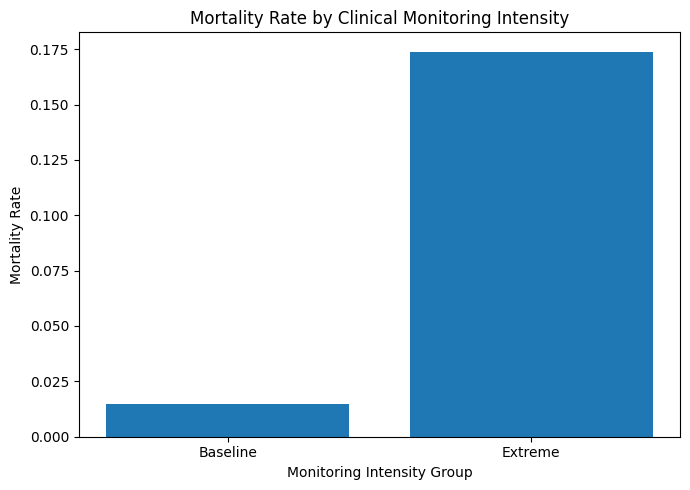

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

plt.bar(
    mortality_by_intensity['monitoring_intensity_group'],
    mortality_by_intensity['mortality_rate']
)

plt.title("Mortality Rate by Clinical Monitoring Intensity")
plt.xlabel("Monitoring Intensity Group")
plt.ylabel("Mortality Rate")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [186]:
hospital_los_mortality = (
    features
    .groupby('hospital_expire_flag')
    .agg(
        mean_los_days=('hospital_los_days', 'mean'),
        median_los_days=('hospital_los_days', 'median'),
        patient_count=('hadm_id', 'count')
    )
    .reset_index()
)

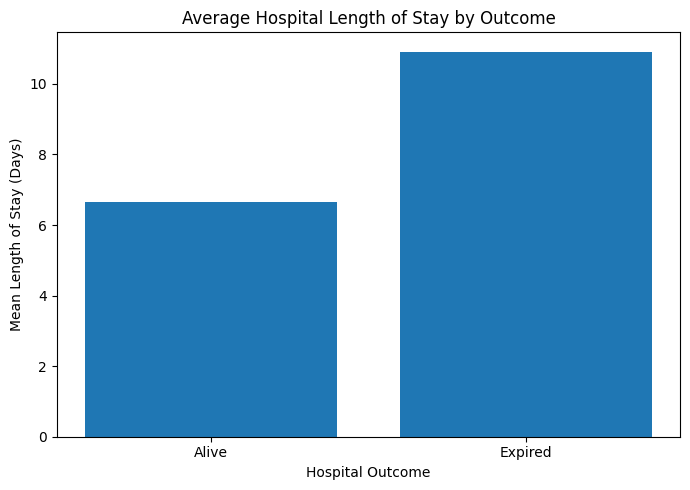

In [189]:
plt.figure(figsize=(7, 5))

plt.bar(
    ['Alive', 'Expired'],
    hospital_los_mortality['mean_los_days']
)

plt.title("Average Hospital Length of Stay by Outcome")
plt.xlabel("Hospital Outcome")
plt.ylabel("Mean Length of Stay (Days)")

plt.tight_layout()
plt.show()


In [6]:
plt.savefig("plots/monitoring_intensity_vs_mortality.png", dpi=150, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [7]:
plt.show()

In [8]:
plt.savefig("plots/los_vs_mortality.png", dpi=150, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [9]:
plt.show()